# DAA Based

Loading CD data...
Loaded data shape: (155, 3296)
Columns: ['Sample', 'Study.Group', 'C18n_QI56__glycochenodeoxycholate', 'C18n_QI66__salicylate', 'C18n_QI1577__NA', 'C18n_QI2961__NA', 'C18n_QI3444__NA', 'C18n_QI1292__NA', 'C18n_QI1541__NA', 'C18n_QI4044__NA']...

Number of metabolic features: 3293

Cluster distribution:
0    108
1     47
Name: count, dtype: int64

Distance matrix shape: (155, 155)
Infinite values in feature matrix: 0
PERMANOVA Analysis for CD K-means Clusters

PERMANOVA Results:
Test statistic: 88.3454
P-value: 0.0010
Number of permutations: 999

✓ SIGNIFICANT: The k-means clusters show significantly different metabolic profiles (p = 0.0010)
  This suggests the clusters represent meaningful biological subtypes, not random groupings.

Effect size (R²): 0.9920
This means 99.2% of the metabolic variation is explained by the clustering.

Results saved to: data/PERMANOVA_results_CD_K2.tsv


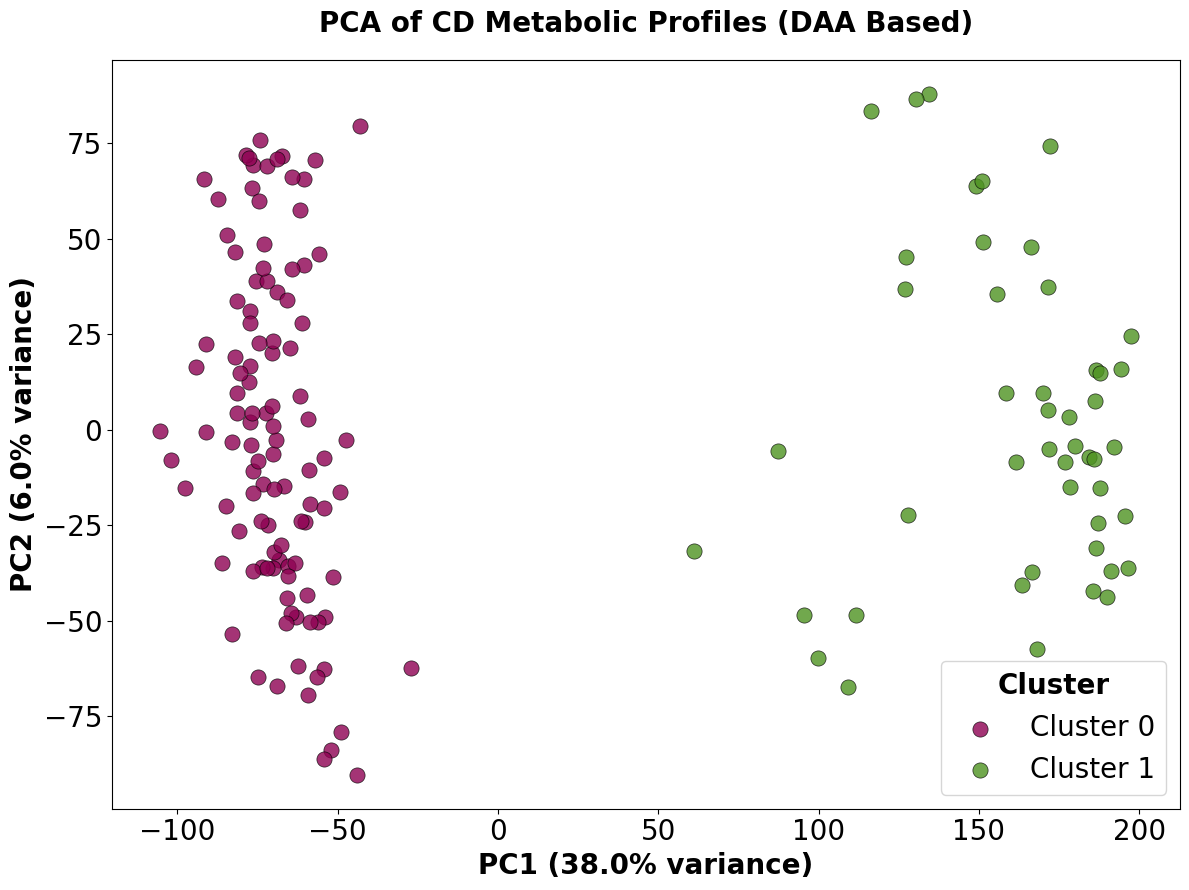

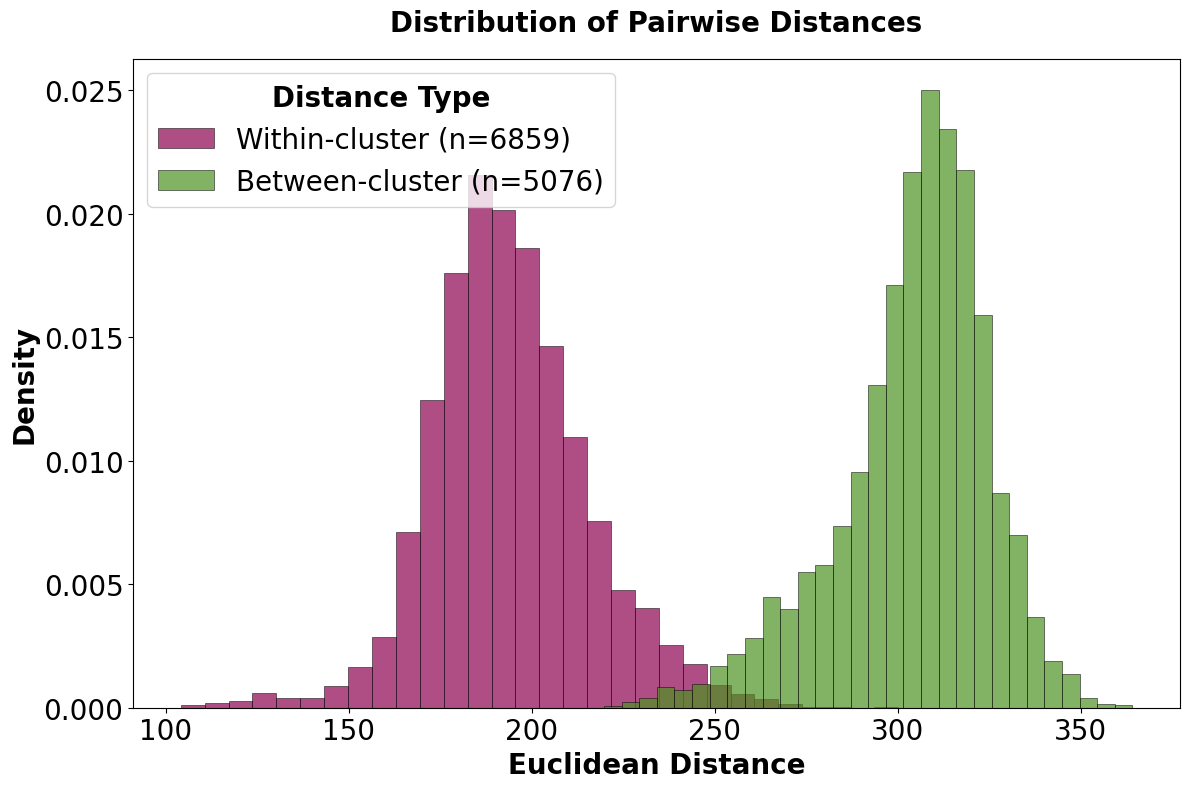

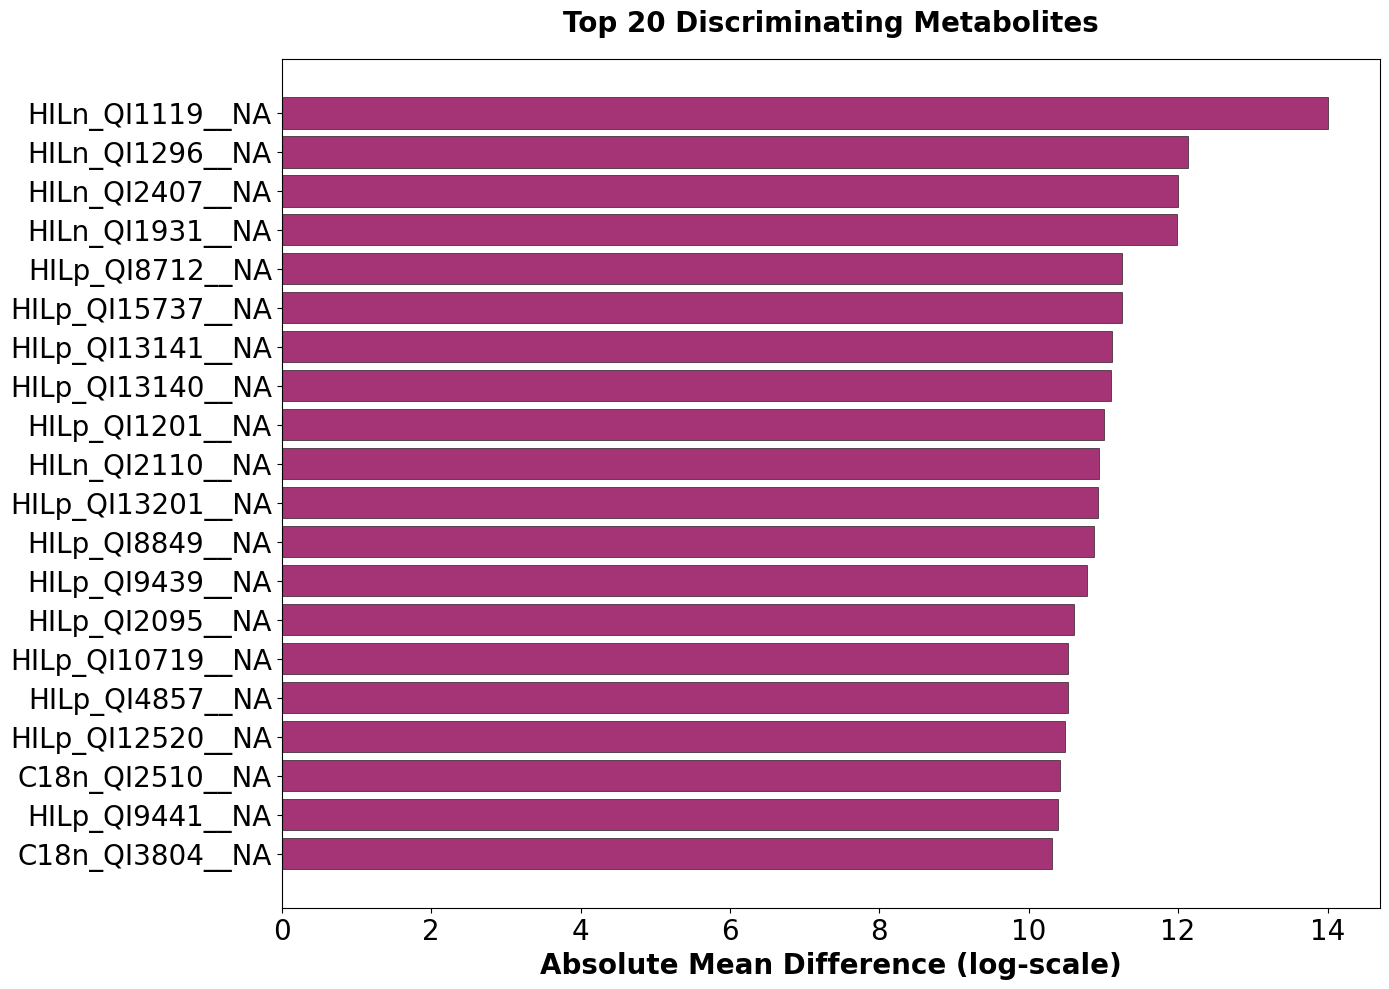

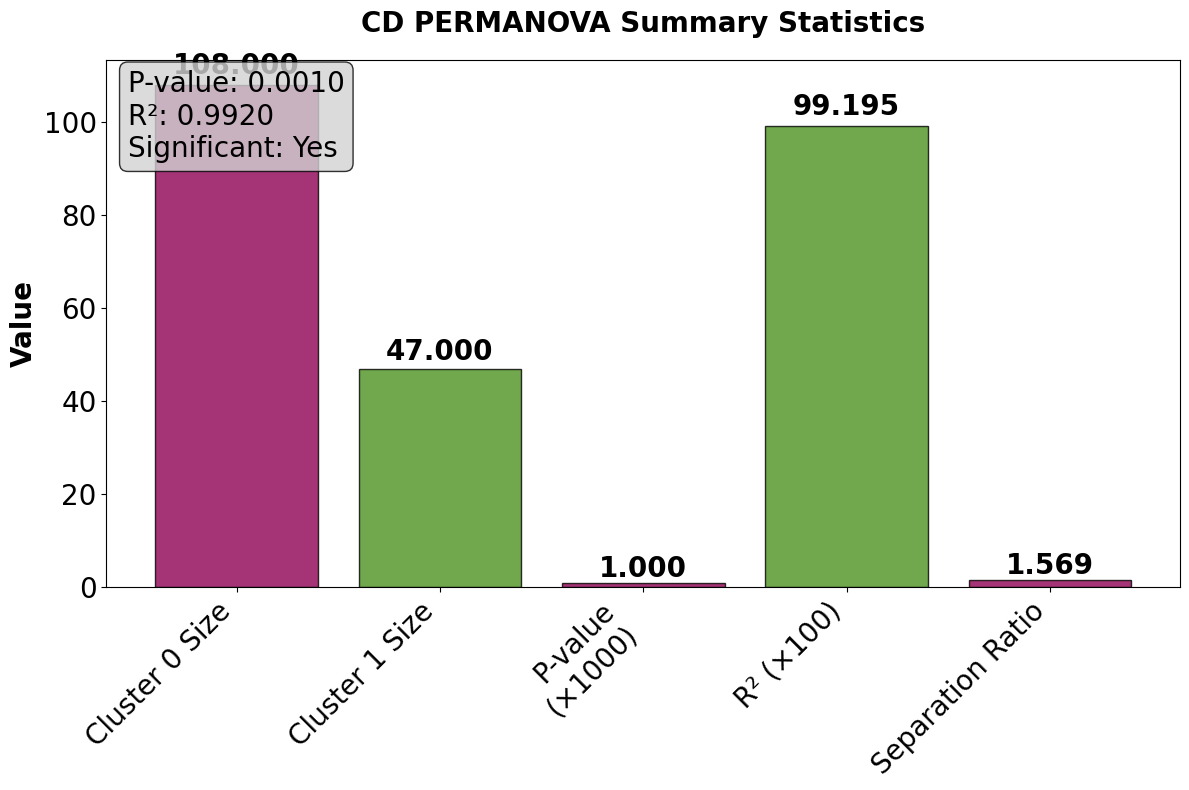


All visualizations saved with prefix: data/PERMANOVA_*_CD_K2.png

Separation ratio (between/within): 1.57

Loading UC data...
Loaded data shape: (96, 3296)
Columns: ['Sample', 'Study.Group', 'C18n_QI56__glycochenodeoxycholate', 'C18n_QI66__salicylate', 'C18n_QI1577__NA', 'C18n_QI2961__NA', 'C18n_QI3444__NA', 'C18n_QI1292__NA', 'C18n_QI1541__NA', 'C18n_QI4044__NA']...

Number of metabolic features: 3293

Cluster distribution:
0    65
1    31
Name: count, dtype: int64

Distance matrix shape: (96, 96)
Infinite values in feature matrix: 0
PERMANOVA Analysis for UC K-means Clusters

PERMANOVA Results:
Test statistic: 46.9499
P-value: 0.0010
Number of permutations: 999

✓ SIGNIFICANT: The k-means clusters show significantly different metabolic profiles (p = 0.0010)
  This suggests the clusters represent meaningful biological subtypes, not random groupings.

Effect size (R²): 0.9858
This means 98.6% of the metabolic variation is explained by the clustering.

Results saved to: data/PERMANOVA_

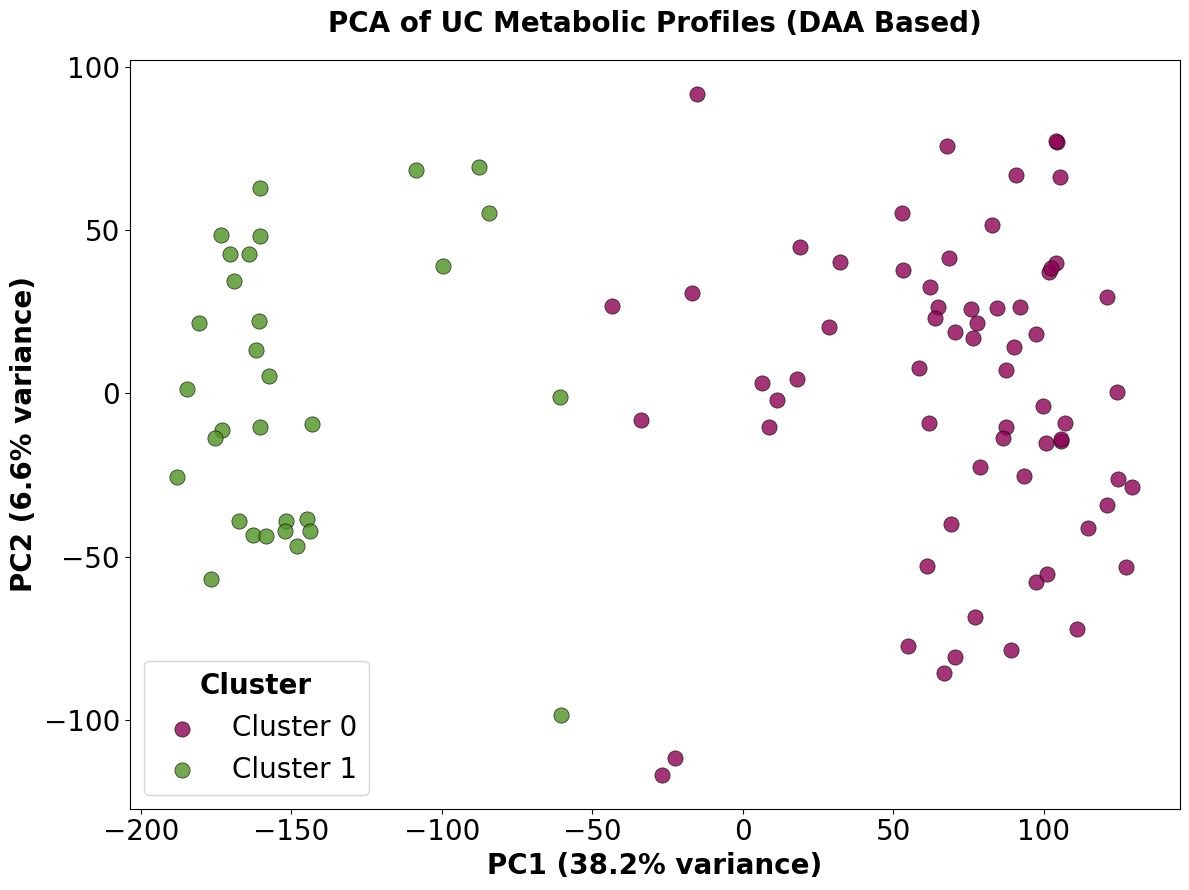

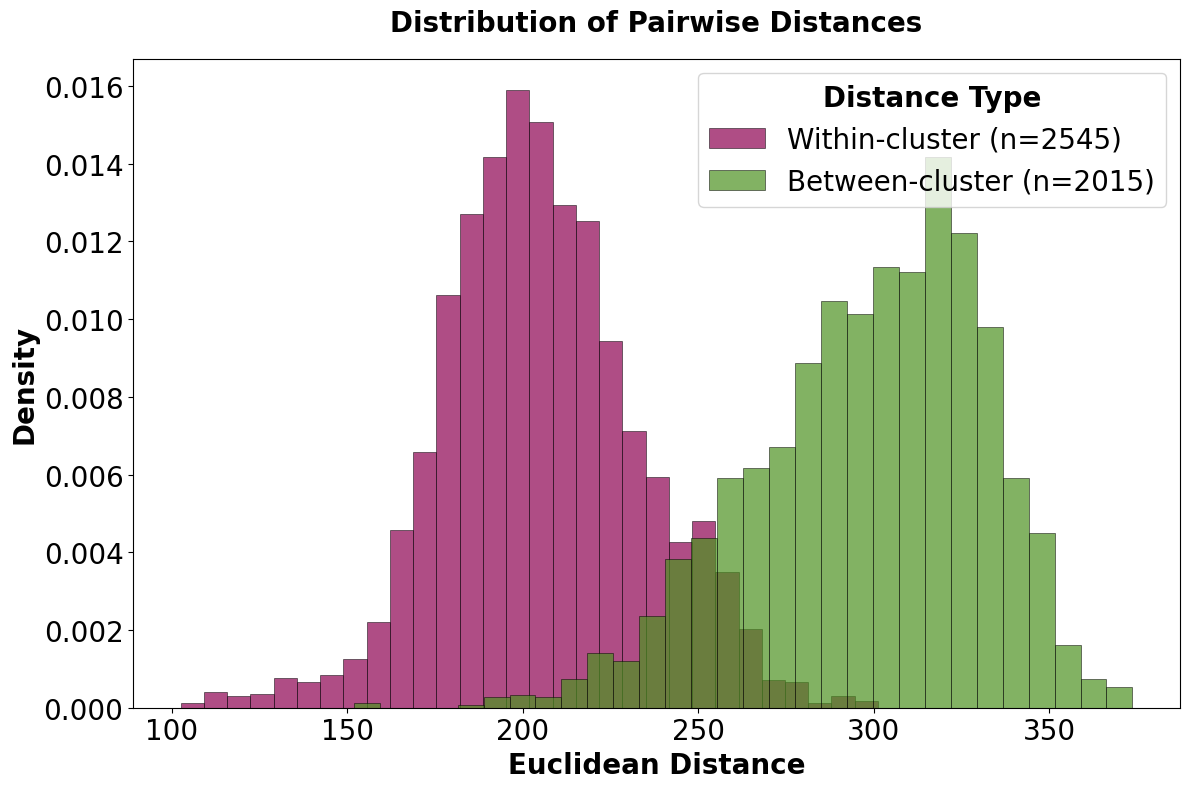

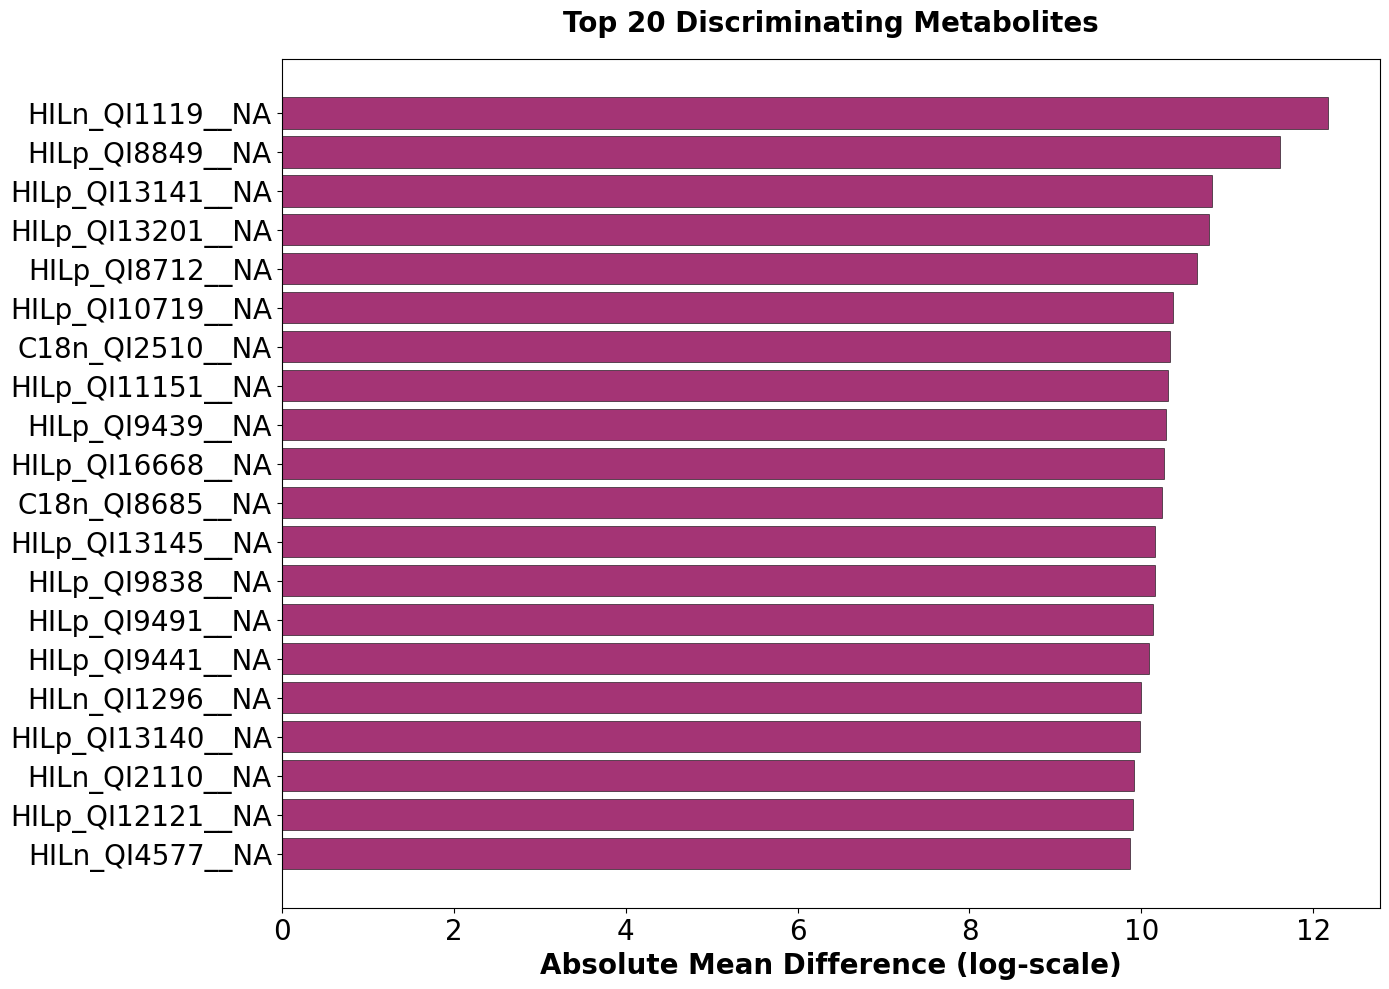

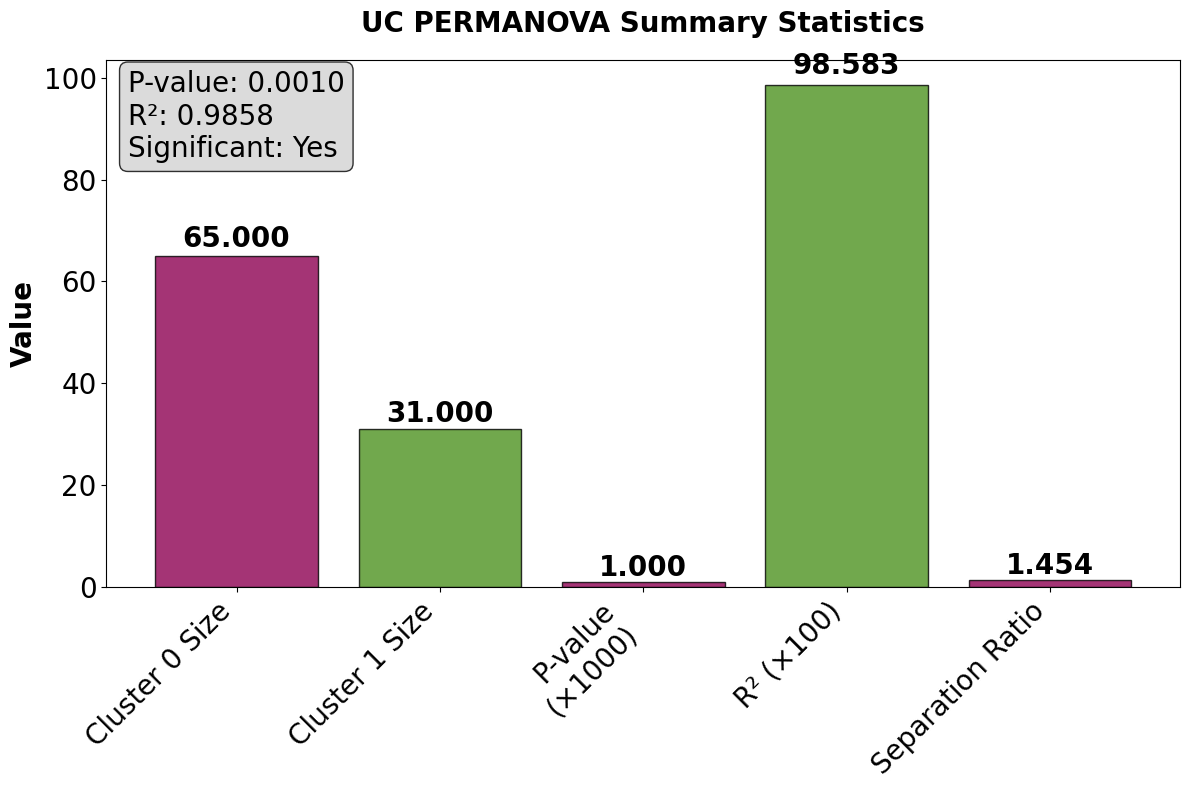


All visualizations saved with prefix: data/PERMANOVA_*_UC_K2.png

Separation ratio (between/within): 1.45

Comparison of CD and UC PERMANOVA Results
  Disease  P-value  R-squared  Cluster_0_Size  Cluster_1_Size  \
0      CD    0.001   0.991951             108              47   
1      UC    0.001   0.985833              65              31   

   Separation_Ratio  
0          1.568900  
1          1.454067  

Comparison saved to: data/CD_UC_PERMANOVA_comparison.tsv


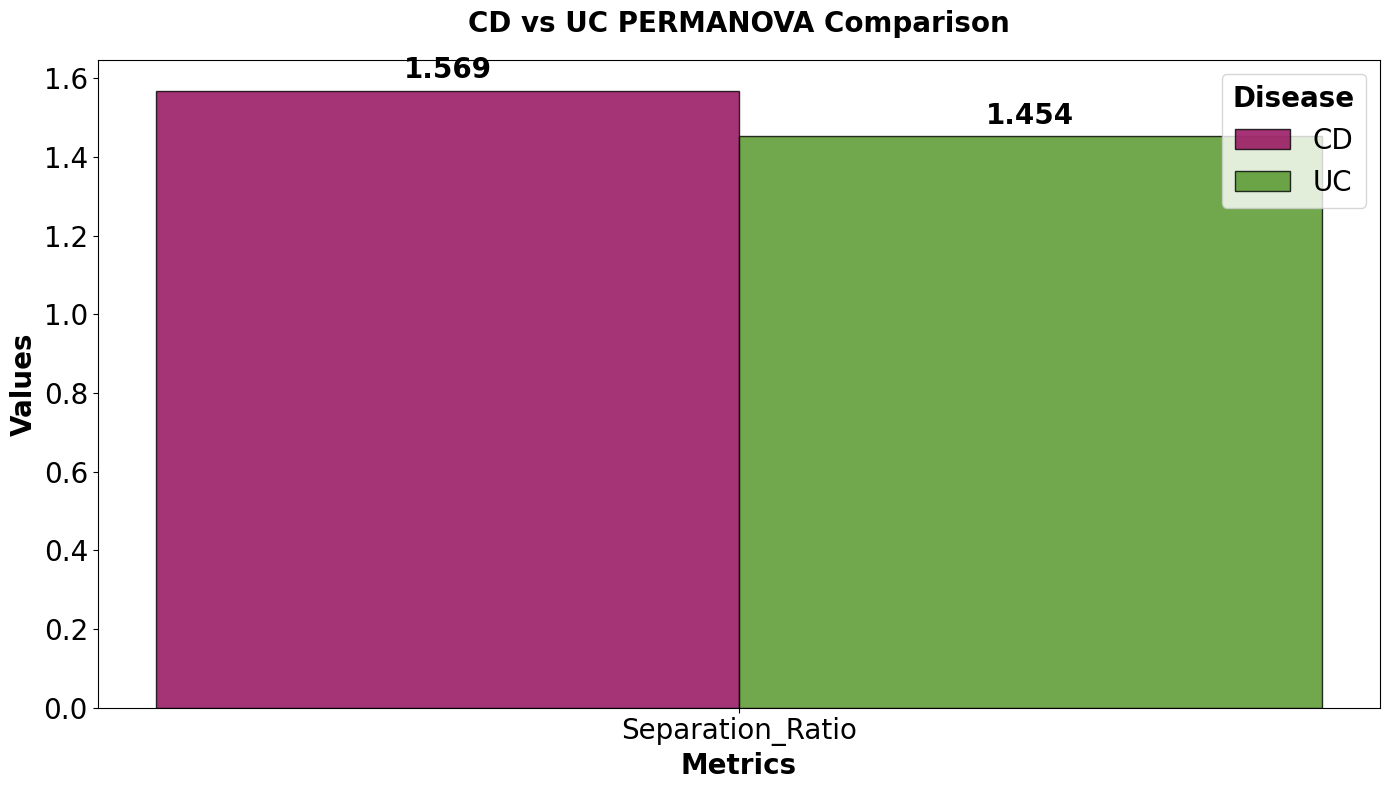


Top discriminating metabolites overlap analysis:
Number of common features between CD and UC: 3293
Number of overlapping discriminating metabolites in top 50: 34
Overlap percentage: 68.0%

Overlapping metabolites (full feature names):
1. HILn_QI2036__NA
2. HILn_QI1296__NA
3. HILn_QI1119__NA
4. C18n_QI2510__NA
5. HILn_QI1804__NA
6. HILp_QI8849__NA
7. HILp_QI1201__NA
8. HILp_QI10676__NA
9. C18n_QI3871__NA
10. HILp_QI21861__NA
11. HILp_QI10272__NA
12. HILp_QI13201__NA
13. C18n_QI3061__NA
14. HILn_QI1931__NA
15. HILp_QI13140__NA
16. HILn_QI1847__NA
17. HILp_QI9838__NA
18. HILp_QI12520__NA
19. HILp_QI10719__NA
20. HILp_QI13141__NA
21. C18n_QI1810__NA
22. HILn_QI1552__NA
23. HILp_QI13680__NA
24. C18n_QI3804__NA
25. HILp_QI8712__NA
26. C18n_QI3125__NA
27. HILp_QI15737__NA
28. HILp_QI9439__NA
29. HILp_QI9441__NA
30. C18n_QI8685__NA
31. HILn_QI2110__NA
32. HILp_QI13198__NA
33. HILp_QI4857__NA
34. HILp_QI15496__NA


In [ ]:
import os
import warnings
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from skbio.stats.distance import permanova
from skbio import DistanceMatrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')

colors = ['#8e0152', '#4d9221']  # Dark pink and dark green

# Function to perform PERMANOVA analysis on a dataset
def perform_permanova_analysis(df, cluster_col, output_prefix):
    print(f"Loaded data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()[:10]}...")
    
    # Identify feature columns (metabolites)
    feature_cols = [col for col in df.columns if col.startswith(('C18n_', 'C8p_', 'HILn_', 'HILp_'))]
    print(f"\nNumber of metabolic features: {len(feature_cols)}")
    
    # Extract features and cluster labels
    X = df[feature_cols].values
    cluster_labels = df[cluster_col].values
    
    print(f"\nCluster distribution:")
    print(pd.Series(cluster_labels).value_counts().sort_index())
    
    # Calculate distance matrix
    dist_matrix = pairwise_distances(X, metric='euclidean')
    print(f"\nDistance matrix shape: {dist_matrix.shape}")
    
    # Handle NaNs and infinities
    nan_count = np.isnan(X).sum()
    if nan_count > 0:
        print("\nHandling NaN values...")
        imputer = SimpleImputer(strategy='mean')
        X_imputed = imputer.fit_transform(X)
        dist_matrix = pairwise_distances(X_imputed, metric='euclidean')
    else:
        inf_count = np.isinf(X).sum()
        print(f"Infinite values in feature matrix: {inf_count}")
        
        if inf_count > 0:
            X_clean = np.copy(X)
            X_clean[np.isinf(X_clean)] = np.nan
            X_clean = np.nan_to_num(X_clean, nan=0.0)
            dist_matrix = pairwise_distances(X_clean, metric='euclidean')
    
    # Final cleaning and symmetry
    dist_matrix = np.nan_to_num(dist_matrix, nan=0.0)
    dist_matrix = (dist_matrix + dist_matrix.T) / 2
    
    # Convert to DistanceMatrix object
    sample_ids = df['Sample'].astype(str).tolist()
    dm = DistanceMatrix(dist_matrix, ids=sample_ids)
    
    # Run PERMANOVA
    print("=" * 50)
    print(f"PERMANOVA Analysis for {output_prefix} K-means Clusters")
    print("=" * 50)
    
    # Create grouping vector for PERMANOVA
    grouping = pd.Series(cluster_labels, index=sample_ids, name="Cluster")
    
    # Run PERMANOVA with 999 permutations
    permanova_results = permanova(dm, grouping, permutations=999)
    
    print("\nPERMANOVA Results:")
    print(f"Test statistic: {permanova_results['test statistic']:.4f}")
    print(f"P-value: {permanova_results['p-value']:.4f}")
    print(f"Number of permutations: {permanova_results['number of permutations']}")
    
    # Interpret results
    if permanova_results['p-value'] < 0.05:
        print(f"\n✓ SIGNIFICANT: The k-means clusters show significantly different metabolic profiles (p = {permanova_results['p-value']:.4f})")
        print("  This suggests the clusters represent meaningful biological subtypes, not random groupings.")
    else:
        print(f"\n✗ NOT SIGNIFICANT: No significant difference between clusters (p = {permanova_results['p-value']:.4f})")
        print("  The clusters might be capturing random variation rather than true biological structure.")
    
    # Calculate effect size (R²)
    total_variance = np.sum(dist_matrix**2) / (len(dist_matrix) * 2)
    within_cluster_distances = []
    between_distances = []
    
    for i in range(len(cluster_labels)):
        for j in range(i+1, len(cluster_labels)):
            if cluster_labels[i] == cluster_labels[j]:
                within_cluster_distances.append(dist_matrix[i, j])
            else:
                between_distances.append(dist_matrix[i, j])
    
    within_variance = np.mean(np.array(within_cluster_distances)**2)
    r_squared = 1 - (within_variance / total_variance)
    
    print(f"\nEffect size (R²): {r_squared:.4f}")
    print(f"This means {r_squared*100:.1f}% of the metabolic variation is explained by the clustering.")
    
    # Save results
    results_summary = {
        'Analysis': f'PERMANOVA_{output_prefix}_K2',
        'Test_Statistic': permanova_results['test statistic'],
        'P_Value': permanova_results['p-value'],
        'Permutations': permanova_results['number of permutations'],
        'R_Squared': r_squared,
        'Cluster_0_Size': sum(cluster_labels == 0),
        'Cluster_1_Size': sum(cluster_labels == 1)
    }
    
    pd.DataFrame([results_summary]).to_csv(f'data/PERMANOVA_results_{output_prefix}_K2.tsv', sep='\t', index=False)
    print(f"\nResults saved to: data/PERMANOVA_results_{output_prefix}_K2.tsv")
    
    # Visualize the cluster separation - Individual plots
    
    # 1. PCA visualization
    plt.figure(figsize=(12, 9))
    pca = PCA(n_components=2)
    pca_coords = pca.fit_transform(X)
    
    # Create scatter plot with custom colors
    for i, cluster in enumerate(np.unique(cluster_labels)):
        mask = cluster_labels == cluster
        plt.scatter(pca_coords[mask, 0], pca_coords[mask, 1], 
                   c=colors[i], label=f'Cluster {cluster}',
                   s=120, alpha=0.8, edgecolors='black', linewidth=0.5)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', 
               fontsize=20, fontweight='semibold')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', 
               fontsize=20, fontweight='semibold')
    plt.title(f'PCA of {output_prefix} Metabolic Profiles (DAA Based)', 
              fontsize=20, fontweight='semibold', pad=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    legend = plt.legend(fontsize=20, title_fontsize=20)
    legend.set_title("Cluster", prop={'size': 20, 'weight': 'semibold'})
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    
    # 2. Distance distribution
    plt.figure(figsize=(12, 8))
    plt.hist(within_cluster_distances, bins=30, alpha=0.7, 
             label=f'Within-cluster (n={len(within_cluster_distances)})', 
             density=True, color=colors[0], edgecolor='black', linewidth=0.5)
    plt.hist(between_distances, bins=30, alpha=0.7, 
             label=f'Between-cluster (n={len(between_distances)})', 
             density=True, color=colors[1], edgecolor='black', linewidth=0.5)
    plt.xlabel('Euclidean Distance', fontsize=20, fontweight='semibold')
    plt.ylabel('Density', fontsize=20, fontweight='semibold')
    plt.title('Distribution of Pairwise Distances', fontsize=20, fontweight='semibold', pad=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    legend = plt.legend(fontsize=20, title_fontsize=20)
    legend.set_title("Distance Type", prop={'size': 20, 'weight': 'semibold'})
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    
    # 3. Top contributing features
    plt.figure(figsize=(14, 10))
    
    # Calculate mean difference between clusters for each feature
    cluster0_mean = X[cluster_labels == 0].mean(axis=0)
    cluster1_mean = X[cluster_labels == 1].mean(axis=0)
    feature_differences = np.abs(cluster0_mean - cluster1_mean)
    
    # Get top 20 features
    top_indices = np.argsort(feature_differences)[-20:]
    top_features = [feature_cols[i] for i in top_indices]
    top_diffs = feature_differences[top_indices]
    
    # Create horizontal bar plot
    bars = plt.barh(range(20), top_diffs, color=colors[0], alpha=0.8, 
                    edgecolor='black', linewidth=0.5)
    plt.yticks(range(20), top_features, fontsize=20)
    plt.xlabel('Absolute Mean Difference (log-scale)', fontsize=20, fontweight='semibold')
    plt.title('Top 20 Discriminating Metabolites', fontsize=20, fontweight='semibold', pad=20)
    plt.xticks(fontsize=20)
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(12, 8))
    
    # Create a summary plot with key statistics
    stats_data = {
        'Metric': ['Cluster 0 Size', 'Cluster 1 Size', 'P-value\n(×1000)', 'R² (×100)', 
                   'Separation Ratio'],
        'Value': [sum(cluster_labels == 0), sum(cluster_labels == 1), 
                  permanova_results['p-value'] * 1000, r_squared * 100,
                  np.mean(between_distances)/np.mean(within_cluster_distances)]
    }
    bars = plt.bar(stats_data['Metric'], stats_data['Value'], 
                   color=[colors[0], colors[1], colors[0], colors[1], colors[0]], 
                   alpha=0.8, edgecolor='black', linewidth=1)
    plt.ylabel('Value', fontsize=20, fontweight='semibold')
    plt.title(f'{output_prefix} PERMANOVA Summary Statistics', 
              fontsize=20, fontweight='semibold', pad=20)
    for bar, value in zip(bars, stats_data['Value']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=20, fontweight='semibold')
    plt.xticks(fontsize=20, rotation=45, ha='right')
    plt.yticks(fontsize=20)
    plt.grid(False)
    textstr = f'P-value: {permanova_results["p-value"]:.4f}\nR²: {r_squared:.4f}\nSignificant: {"Yes" if permanova_results["p-value"] < 0.05 else "No"}'
    props = dict(boxstyle='round', facecolor='lightgray', alpha=0.8)
    plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=20,
             verticalalignment='top', bbox=props)
    plt.tight_layout()
    plt.show()
    
    print(f"\nAll visualizations saved with prefix: data/PERMANOVA_*_{output_prefix}_K2.png")
    print(f"\nSeparation ratio (between/within): {np.mean(between_distances)/np.mean(within_cluster_distances):.2f}")
    
    return {
        'feature_cols': feature_cols,
        'X': X,
        'cluster_labels': cluster_labels,
        'permanova_results': permanova_results,
        'r_squared': r_squared,
        'separation_ratio': np.mean(between_distances)/np.mean(within_cluster_distances),
        'feature_differences': feature_differences
    }

os.makedirs('data', exist_ok=True)
# Load data for CD
print("Loading CD data...")
cd_clustered_file = 'processing_data/cd_clusters/cd_clustered_df_k2.tsv'
cd_df = pd.read_csv(cd_clustered_file, sep='\t')
cd_results = perform_permanova_analysis(cd_df, 'KMeans_Cluster_CD_K2', 'CD')

# Load data for UC
print("\nLoading UC data...")
uc_clustered_file = 'processing_data/uc_clusters/uc_clustered_df_k2.tsv'
uc_df = pd.read_csv(uc_clustered_file, sep='\t')
uc_results = perform_permanova_analysis(uc_df, 'KMeans_Cluster_UC_K2', 'UC')

# Compare CD and UC results
print("\n" + "="*50)
print("Comparison of CD and UC PERMANOVA Results")
print("="*50)

comparison_df = pd.DataFrame([
    {'Disease': 'CD', 'P-value': cd_results['permanova_results']['p-value'], 
     'R-squared': cd_results['r_squared'], 
     'Cluster_0_Size': sum(cd_results['cluster_labels'] == 0), 
     'Cluster_1_Size': sum(cd_results['cluster_labels'] == 1),
     'Separation_Ratio': cd_results['separation_ratio']},
    {'Disease': 'UC', 'P-value': uc_results['permanova_results']['p-value'], 
     'R-squared': uc_results['r_squared'], 
     'Cluster_0_Size': sum(uc_results['cluster_labels'] == 0), 
     'Cluster_1_Size': sum(uc_results['cluster_labels'] == 1),
     'Separation_Ratio': uc_results['separation_ratio']}
])

print(comparison_df)

# Save comparison
comparison_df.to_csv('data/CD_UC_PERMANOVA_comparison.tsv', sep='\t', index=False)
print("\nComparison saved to: data/CD_UC_PERMANOVA_comparison.tsv")

# Visualize comparison between CD and UC
plt.figure(figsize=(14, 8))

# Create comparison plot
metrics = ['Separation_Ratio']
cd_values = cd_results['separation_ratio']
uc_values = uc_results['separation_ratio']

x = np.arange(len(metrics))
width = 0.35
bars1 = plt.bar(x - width/2, cd_values, width, label='CD', 
                color=colors[0], alpha=0.8, edgecolor='black', linewidth=1)
bars2 = plt.bar(x + width/2, uc_values, width, label='UC', 
                color=colors[1], alpha=0.8, edgecolor='black', linewidth=1)
plt.xlabel('Metrics', fontsize=20, fontweight='semibold')
plt.ylabel('Values', fontsize=20, fontweight='semibold')
plt.title('CD vs UC PERMANOVA Comparison', fontsize=20, fontweight='semibold', pad=20)
plt.xticks(x, metrics, fontsize=20)
plt.yticks(fontsize=20)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=20, fontweight='semibold')

legend = plt.legend(fontsize=20, title_fontsize=20)
legend.set_title("Disease", prop={'size': 20, 'weight': 'semibold'})
plt.grid(False)
plt.tight_layout()
plt.savefig('data/CD_UC_PERMANOVA_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Compare top discriminating metabolites
print("\nTop discriminating metabolites overlap analysis:")

# Get CD feature differences and columns
cd_feature_cols = cd_results['feature_cols']
cd_feature_differences = cd_results['feature_differences']

# Get UC feature differences and columns
uc_feature_cols = uc_results['feature_cols']
uc_feature_differences = uc_results['feature_differences']

# Find common features between CD and UC datasets
common_features = set(cd_feature_cols).intersection(set(uc_feature_cols))
print(f"Number of common features between CD and UC: {len(common_features)}")

# Get top 50 metabolites for each disease using their respective feature sets
top50_cd = set([cd_feature_cols[i] for i in np.argsort(cd_feature_differences)[-50:]])
top50_uc = set([uc_feature_cols[i] for i in np.argsort(uc_feature_differences)[-50:]])

# Calculate overlap (only consider features present in both datasets)
overlap = top50_cd.intersection(top50_uc)
print(f"Number of overlapping discriminating metabolites in top 50: {len(overlap)}")
print(f"Overlap percentage: {len(overlap)/50*100:.1f}%")

if len(overlap) > 0:
    print("\nOverlapping metabolites (full feature names):")
    for i, metabolite in enumerate(overlap, 1):
        print(f"{i}. {metabolite}")

# Boruta Based

Loading CD data...
Loaded data shape: (155, 616)
Columns: ['Sample', 'Study.Group', 'C18n_QI3060__NA', 'C18n_QI3276__NA', 'C18n_QI13546__NA', 'C18n_QI1015__NA', 'C18n_QI9709__NA', 'HILn_QI1058__NA', 'C18n_QI2043__NA', 'C18n_QI8815__NA']...

Number of metabolic features: 613

Cluster distribution:
0    108
1     47
Name: count, dtype: int64

Distance matrix shape: (155, 155)
Infinite values in feature matrix: 0
PERMANOVA Analysis for CD K-means Clusters

PERMANOVA Results:
Test statistic: 141.0520
P-value: 0.0010
Number of permutations: 999

✓ SIGNIFICANT: The k-means clusters show significantly different metabolic profiles (p = 0.0010)
  This suggests the clusters represent meaningful biological subtypes, not random groupings.

Effect size (R²): 0.9933
This means 99.3% of the metabolic variation is explained by the clustering.

Results saved to: boruta_data/PERMANOVA_results_CD_K2.tsv


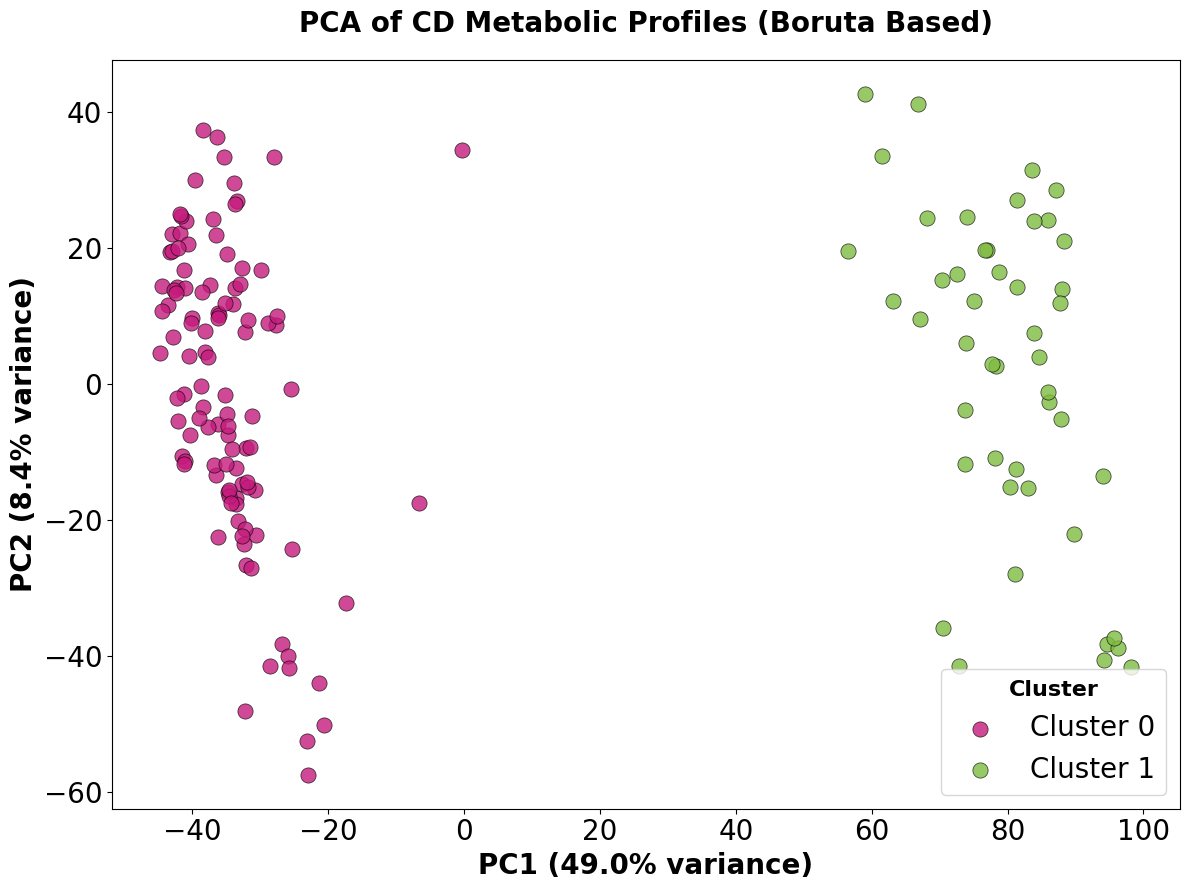

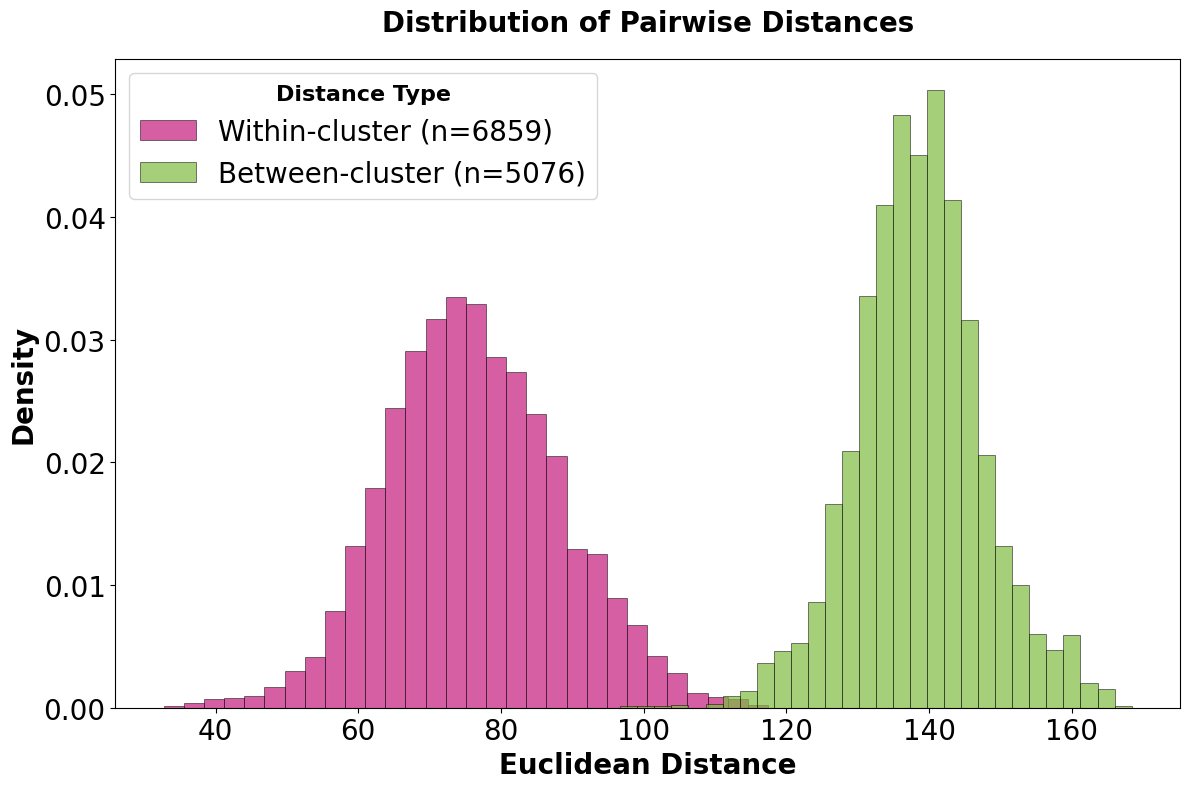

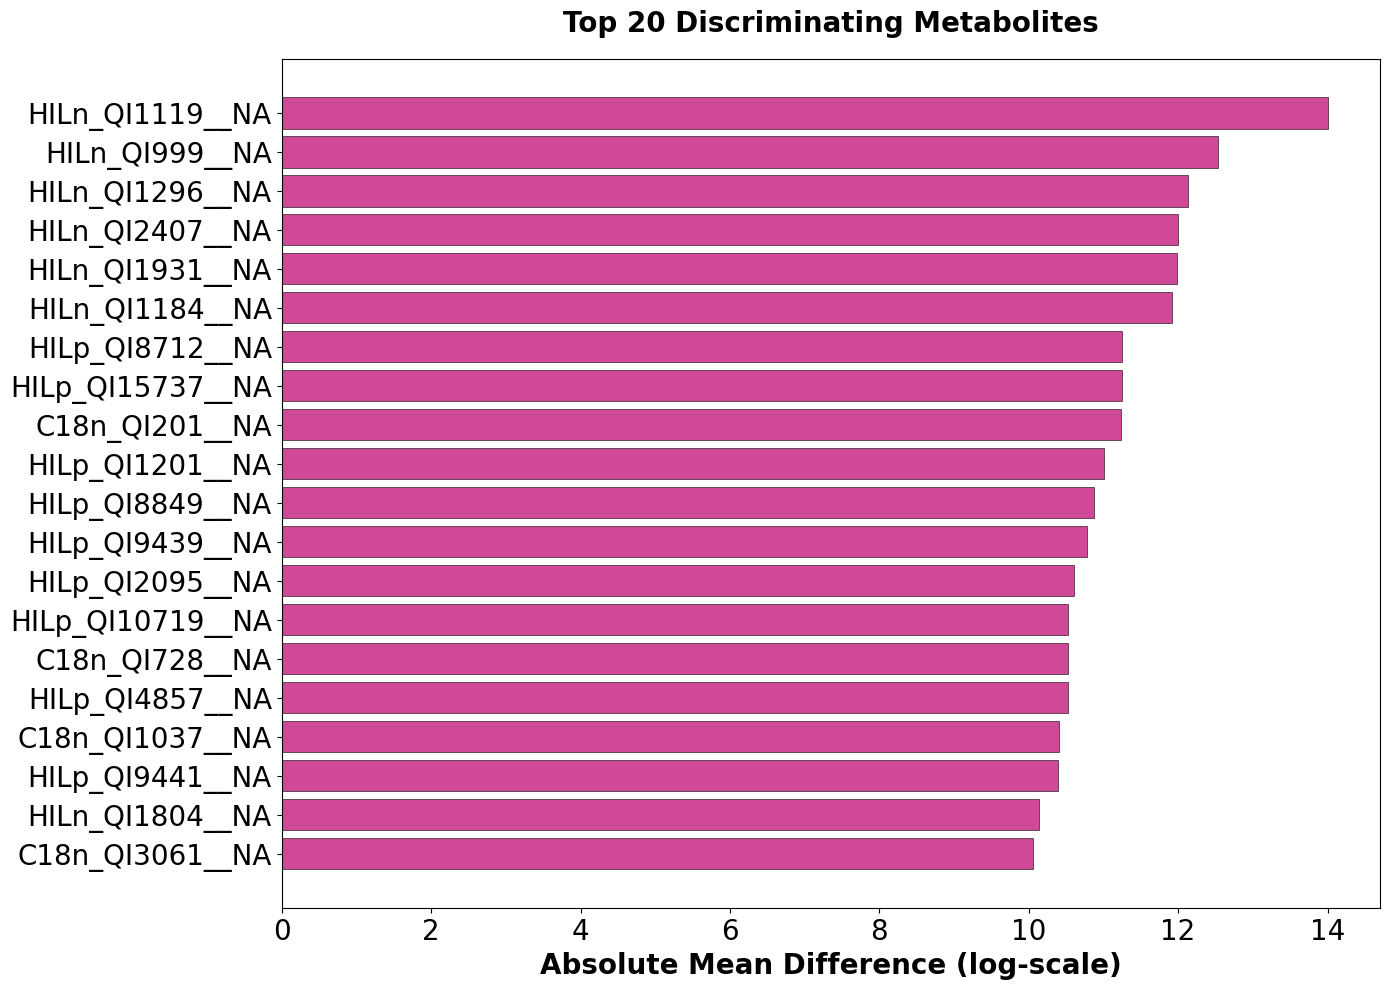

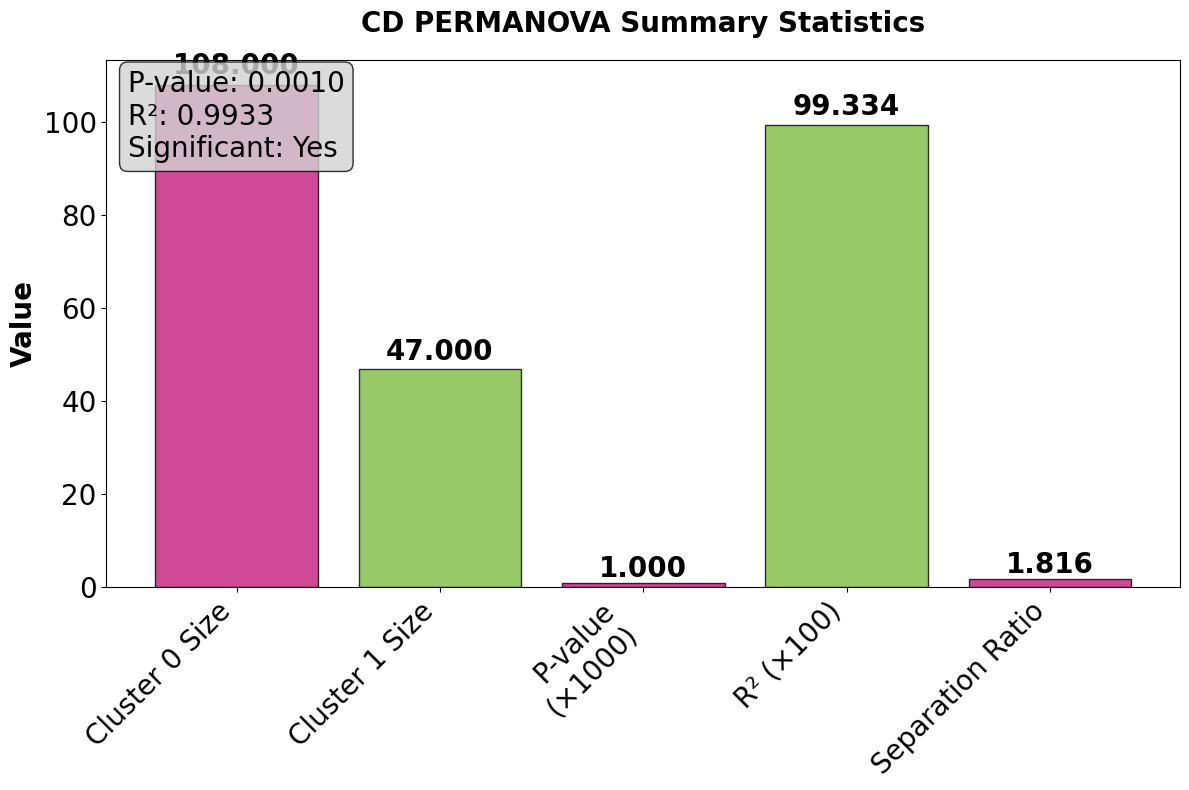


Separation ratio (between/within): 1.82

Loading UC data...
Loaded data shape: (96, 616)
Columns: ['Sample', 'Study.Group', 'C18n_QI3060__NA', 'C18n_QI3276__NA', 'C18n_QI13546__NA', 'C18n_QI1015__NA', 'C18n_QI9709__NA', 'HILn_QI1058__NA', 'C18n_QI2043__NA', 'C18n_QI8815__NA']...

Number of metabolic features: 613

Cluster distribution:
0    70
1    26
Name: count, dtype: int64

Distance matrix shape: (96, 96)
Infinite values in feature matrix: 0
PERMANOVA Analysis for UC K-means Clusters

PERMANOVA Results:
Test statistic: 73.1155
P-value: 0.0010
Number of permutations: 999

✓ SIGNIFICANT: The k-means clusters show significantly different metabolic profiles (p = 0.0010)
  This suggests the clusters represent meaningful biological subtypes, not random groupings.

Effect size (R²): 0.9885
This means 98.9% of the metabolic variation is explained by the clustering.

Results saved to: boruta_data/PERMANOVA_results_UC_K2.tsv


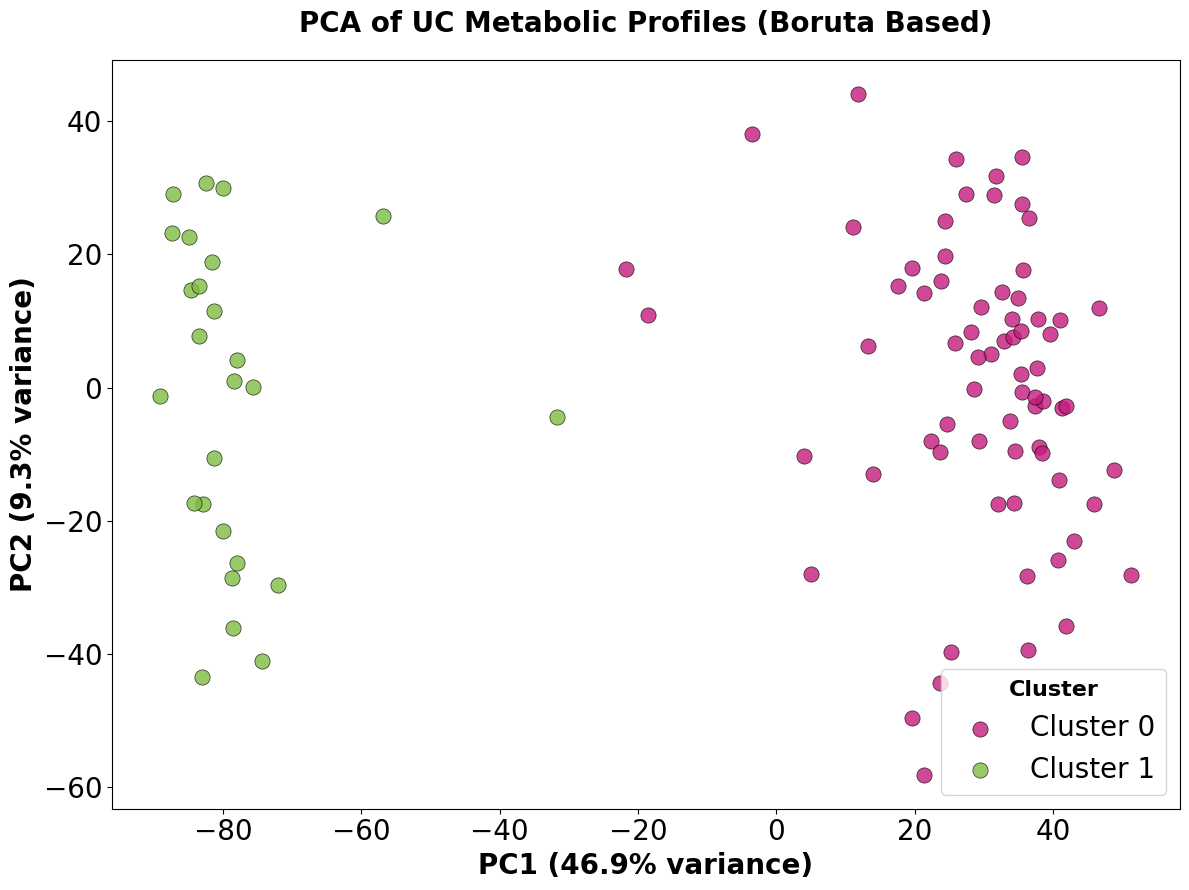

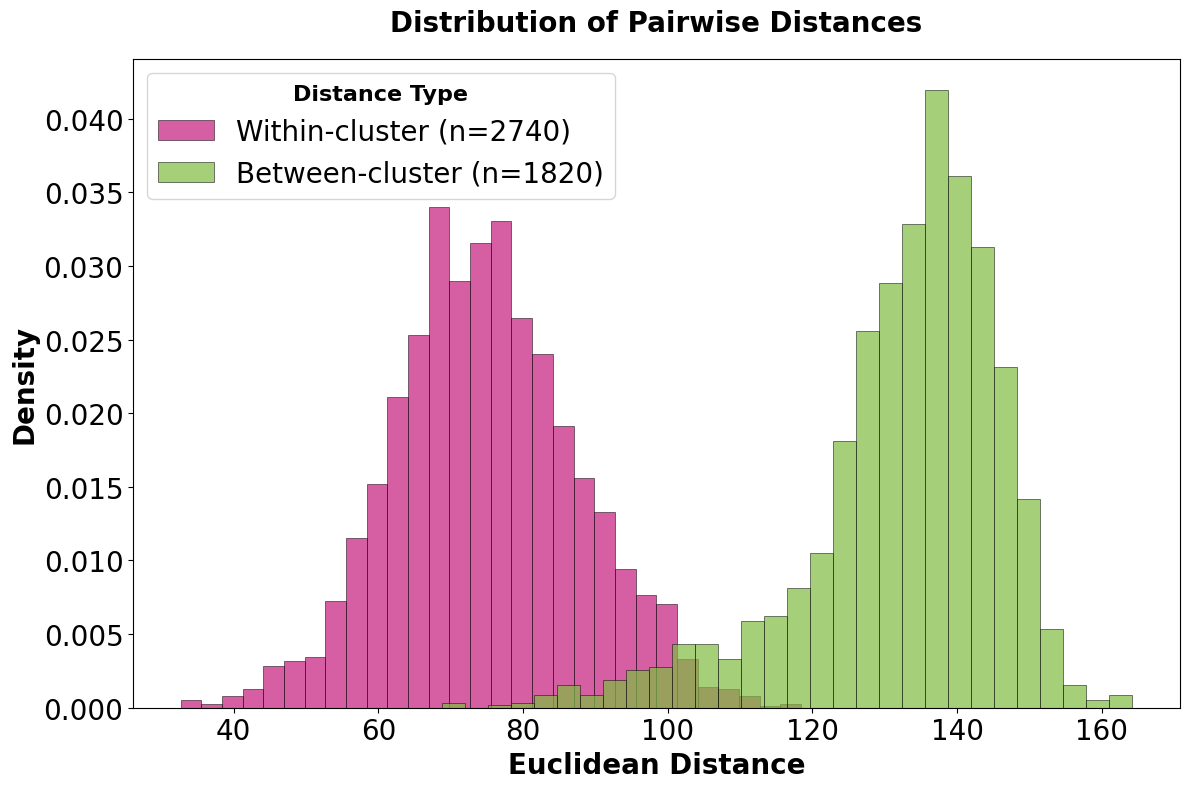

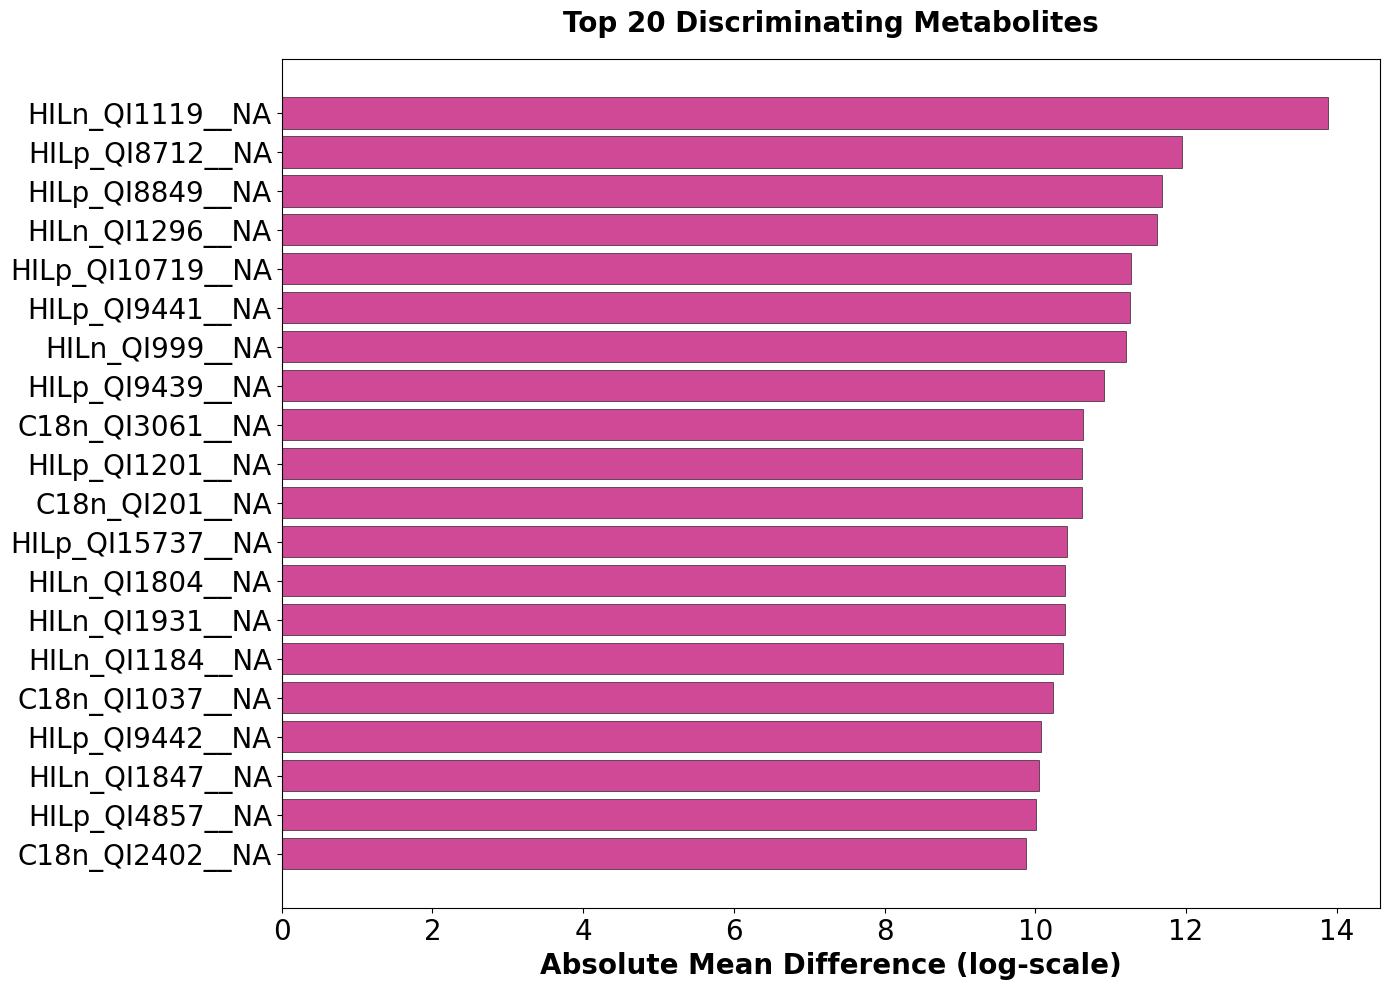

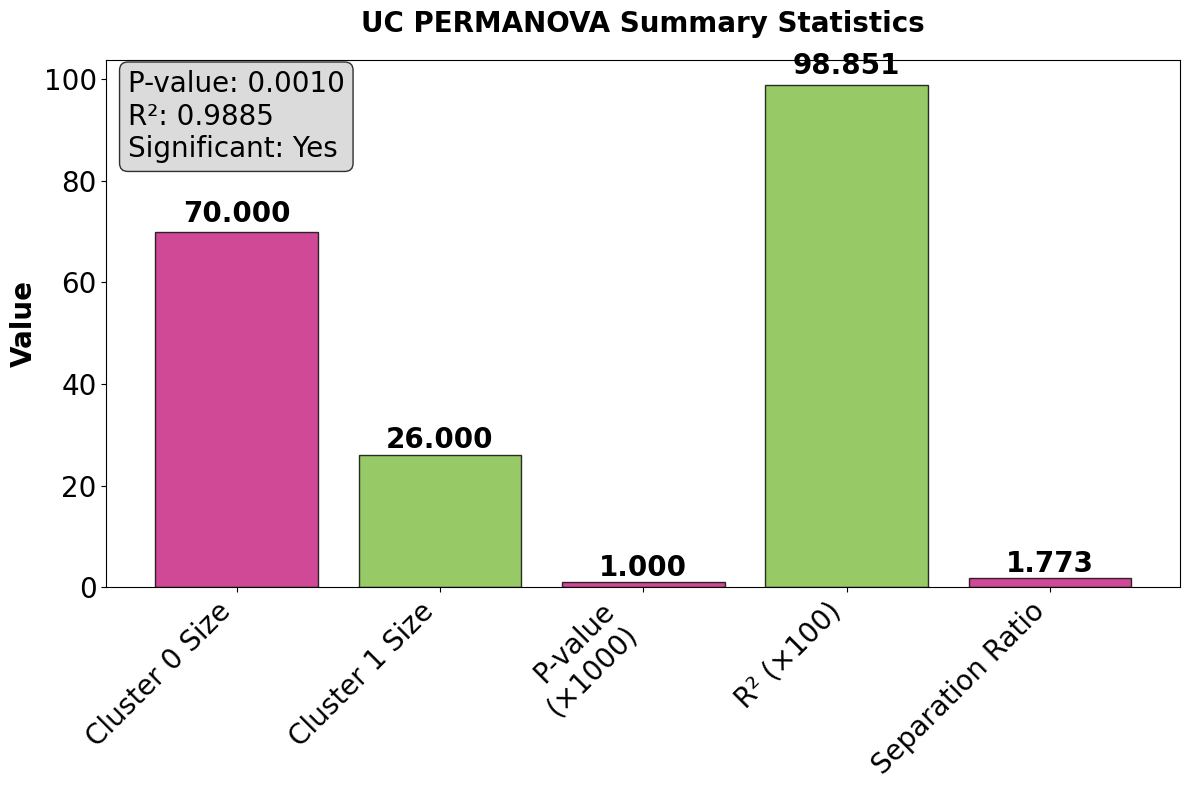


Separation ratio (between/within): 1.77

Comparison of CD and UC PERMANOVA Results
  Disease  P-value  R-squared  Cluster_0_Size  Cluster_1_Size  \
0      CD    0.001   0.993336             108              47   
1      UC    0.001   0.988514              70              26   

   Separation_Ratio  
0          1.816498  
1          1.772936  

Comparison saved to: boruta_data/CD_UC_PERMANOVA_comparison.tsv


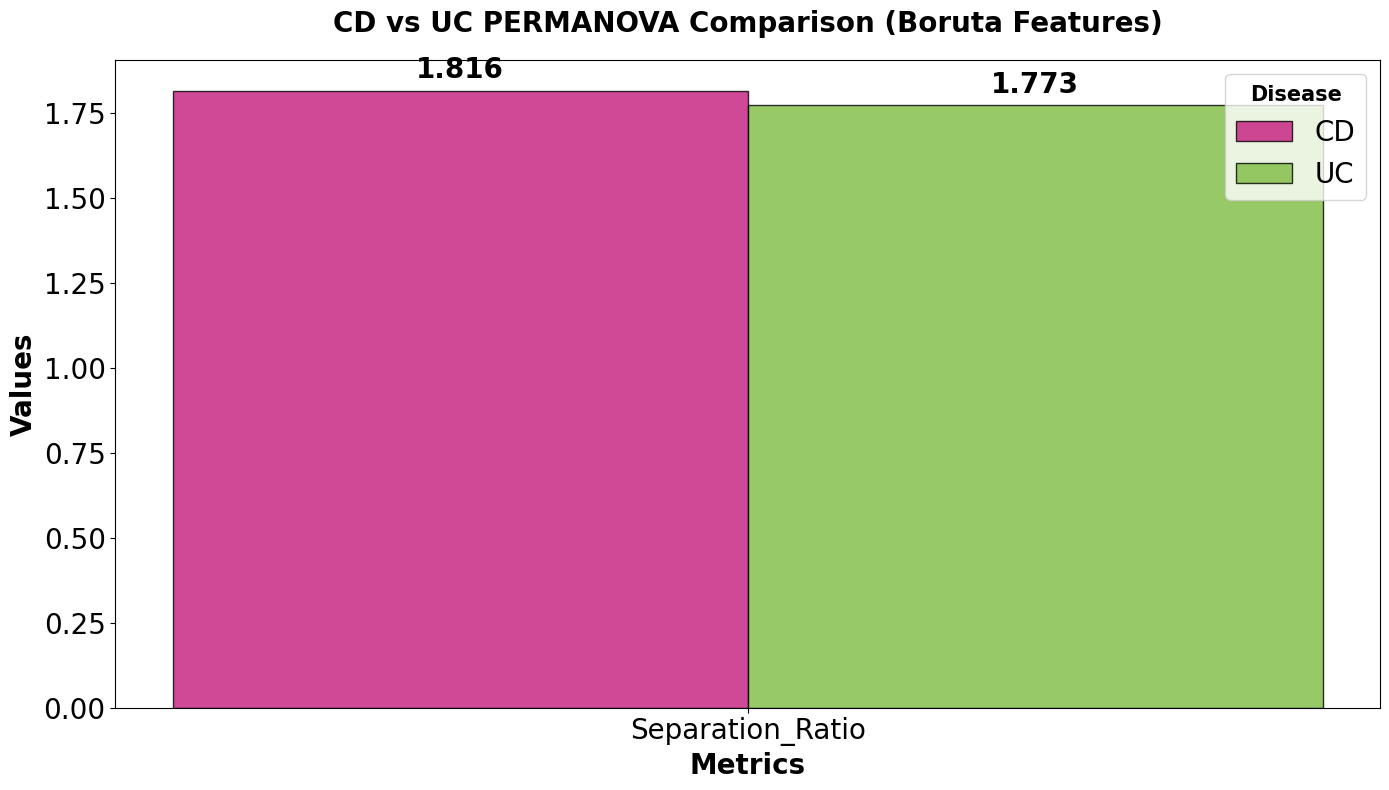


Top discriminating metabolites overlap analysis:
Number of common features between CD and UC: 613
Number of overlapping discriminating metabolites in top 50: 42
Overlap percentage: 84.0%

Overlapping metabolites (full feature names):
1. HILn_QI2407__NA
2. HILn_QI1119__NA
3. HILn_QI1296__NA
4. C18n_QI4450__NA
5. HILn_QI1804__NA
6. HILp_QI4856__NA
7. HILp_QI8849__NA
8. HILp_QI8656__NA
9. HILp_QI1201__NA
10. C18n_QI201__NA
11. HILp_QI19159__NA
12. C18n_QI2084__NA
13. C18n_QI3061__NA
14. HILp_QI2095__NA
15. C18n_QI2189__NA
16. HILn_QI1058__NA
17. HILn_QI1931__NA
18. C18n_QI7190__NA
19. HILn_QI1847__NA
20. C8p_QI809__NA
21. HILn_QI999__NA
22. HILn_QI1184__NA
23. HILp_QI10719__NA
24. C18n_QI1037__NA
25. C18n_QI3060__NA
26. C18n_QI728__NA
27. HILp_QI8848__NA
28. HILp_QI8712__NA
29. HILp_QI15737__NA
30. HILp_QI9439__NA
31. HILp_QI3825__NA
32. HILp_QI4858__NA
33. HILp_QI4857__NA
34. C18n_QI6117__NA
35. HILn_QI2019__NA
36. C18n_QI3161__NA
37. HILp_QI9442__NA
38. HILp_QI9441__NA
39. HILp_QI3769_

In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from skbio.stats.distance import permanova
from skbio import DistanceMatrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

colors = ['#c51b7d', '#7fbc41']  # Dark pink and dark green

# Function to perform PERMANOVA analysis on a dataset
def perform_permanova_analysis(df, cluster_col, output_prefix):
    print(f"Loaded data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()[:10]}...")
    
    # Identify feature columns (metabolites)
    feature_cols = [col for col in df.columns if col.startswith(('C18n_', 'C8p_', 'HILn_', 'HILp_'))]
    print(f"\nNumber of metabolic features: {len(feature_cols)}")
    
    # Extract features and cluster labels
    X = df[feature_cols].values
    cluster_labels = df[cluster_col].values
    
    print(f"\nCluster distribution:")
    print(pd.Series(cluster_labels).value_counts().sort_index())
    
    # Calculate distance matrix
    dist_matrix = pairwise_distances(X, metric='euclidean')
    print(f"\nDistance matrix shape: {dist_matrix.shape}")
    
    # Handle NaNs and infinities
    nan_count = np.isnan(X).sum()
    if nan_count > 0:
        print("\nHandling NaN values...")
        imputer = SimpleImputer(strategy='mean')
        X_imputed = imputer.fit_transform(X)
        dist_matrix = pairwise_distances(X_imputed, metric='euclidean')
    else:
        inf_count = np.isinf(X).sum()
        print(f"Infinite values in feature matrix: {inf_count}")
        
        if inf_count > 0:
            X_clean = np.copy(X)
            X_clean[np.isinf(X_clean)] = np.nan
            X_clean = np.nan_to_num(X_clean, nan=0.0)
            dist_matrix = pairwise_distances(X_clean, metric='euclidean')
    
    # Final cleaning and symmetry
    dist_matrix = np.nan_to_num(dist_matrix, nan=0.0)
    dist_matrix = (dist_matrix + dist_matrix.T) / 2
    
    # Convert to DistanceMatrix object
    sample_ids = df['Sample'].astype(str).tolist()
    dm = DistanceMatrix(dist_matrix, ids=sample_ids)
    
    # Run PERMANOVA
    print("=" * 50)
    print(f"PERMANOVA Analysis for {output_prefix} K-means Clusters")
    print("=" * 50)
    
    # Create grouping vector for PERMANOVA
    grouping = pd.Series(cluster_labels, index=sample_ids, name="Cluster")
    
    # Run PERMANOVA with 999 permutations
    permanova_results = permanova(dm, grouping, permutations=999)
    
    print("\nPERMANOVA Results:")
    print(f"Test statistic: {permanova_results['test statistic']:.4f}")
    print(f"P-value: {permanova_results['p-value']:.4f}")
    print(f"Number of permutations: {permanova_results['number of permutations']}")
    
    # Interpret results
    if permanova_results['p-value'] < 0.05:
        print(f"\n✓ SIGNIFICANT: The k-means clusters show significantly different metabolic profiles (p = {permanova_results['p-value']:.4f})")
        print("  This suggests the clusters represent meaningful biological subtypes, not random groupings.")
    else:
        print(f"\n✗ NOT SIGNIFICANT: No significant difference between clusters (p = {permanova_results['p-value']:.4f})")
        print("  The clusters might be capturing random variation rather than true biological structure.")
    
    # Calculate effect size (R²)
    total_variance = np.sum(dist_matrix**2) / (len(dist_matrix) * 2)
    within_cluster_distances = []
    between_distances = []
    
    for i in range(len(cluster_labels)):
        for j in range(i+1, len(cluster_labels)):
            if cluster_labels[i] == cluster_labels[j]:
                within_cluster_distances.append(dist_matrix[i, j])
            else:
                between_distances.append(dist_matrix[i, j])
    
    within_variance = np.mean(np.array(within_cluster_distances)**2)
    r_squared = 1 - (within_variance / total_variance)
    
    print(f"\nEffect size (R²): {r_squared:.4f}")
    print(f"This means {r_squared*100:.1f}% of the metabolic variation is explained by the clustering.")
    
    # Save results
    results_summary = {
        'Analysis': f'PERMANOVA_{output_prefix}_K2',
        'Test_Statistic': permanova_results['test statistic'],
        'P_Value': permanova_results['p-value'],
        'Permutations': permanova_results['number of permutations'],
        'R_Squared': r_squared,
        'Cluster_0_Size': sum(cluster_labels == 0),
        'Cluster_1_Size': sum(cluster_labels == 1)
    }
    
    pd.DataFrame([results_summary]).to_csv(f'boruta_data/PERMANOVA_results_{output_prefix}_K2.tsv', sep='\t', index=False)
    print(f"\nResults saved to: boruta_data/PERMANOVA_results_{output_prefix}_K2.tsv")
    
    # Visualize the cluster separation - Individual plots
    
    # 1. PCA visualization
    plt.figure(figsize=(12, 9))
    pca = PCA(n_components=2)
    pca_coords = pca.fit_transform(X)
    
    # Create scatter plot with custom colors
    for i, cluster in enumerate(np.unique(cluster_labels)):
        mask = cluster_labels == cluster
        plt.scatter(pca_coords[mask, 0], pca_coords[mask, 1], 
                   c=colors[i], label=f'Cluster {cluster}',
                   s=120, alpha=0.8, edgecolors='black', linewidth=0.5)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', 
               fontsize=20, fontweight='semibold')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', 
               fontsize=20, fontweight='semibold')
    plt.title(f'PCA of {output_prefix} Metabolic Profiles (Boruta Based)', 
              fontsize=20, fontweight='semibold', pad=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    legend = plt.legend(fontsize=20, title_fontsize=20)
    legend.set_title("Cluster", prop={'size': 16, 'weight': 'semibold'})
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    
    # 2. Distance distribution
    plt.figure(figsize=(12, 8))
    plt.hist(within_cluster_distances, bins=30, alpha=0.7, 
             label=f'Within-cluster (n={len(within_cluster_distances)})', 
             density=True, color=colors[0], edgecolor='black', linewidth=0.5)
    plt.hist(between_distances, bins=30, alpha=0.7, 
             label=f'Between-cluster (n={len(between_distances)})', 
             density=True, color=colors[1], edgecolor='black', linewidth=0.5)
    plt.xlabel('Euclidean Distance', fontsize=20, fontweight='semibold')
    plt.ylabel('Density', fontsize=20, fontweight='semibold')
    plt.title('Distribution of Pairwise Distances', fontsize=20, fontweight='semibold', pad=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    legend = plt.legend(fontsize=20, title_fontsize=20)
    legend.set_title("Distance Type", prop={'size': 16, 'weight': 'semibold'})
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    
    # 3. Top contributing features
    plt.figure(figsize=(14, 10))
    
    # Calculate mean difference between clusters for each feature
    cluster0_mean = X[cluster_labels == 0].mean(axis=0)
    cluster1_mean = X[cluster_labels == 1].mean(axis=0)
    feature_differences = np.abs(cluster0_mean - cluster1_mean)
    
    # Get top 20 features
    top_indices = np.argsort(feature_differences)[-20:]
    top_features = [feature_cols[i] for i in top_indices]
    top_diffs = feature_differences[top_indices]
    
    # Create horizontal bar plot
    bars = plt.barh(range(20), top_diffs, color=colors[0], alpha=0.8, 
                    edgecolor='black', linewidth=0.5)
    plt.yticks(range(20), top_features, fontsize=20)
    plt.xlabel('Absolute Mean Difference (log-scale)', fontsize=20, fontweight='semibold')
    plt.title('Top 20 Discriminating Metabolites', fontsize=20, fontweight='semibold', pad=20)
    plt.xticks(fontsize=20)
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    
    # 4. Summary statistics visualization
    plt.figure(figsize=(12, 8))
    # Create a summary plot with key statistics
    stats_data = {
        'Metric': ['Cluster 0 Size', 'Cluster 1 Size', 'P-value\n(×1000)', 'R² (×100)', 
                   'Separation Ratio'],
        'Value': [sum(cluster_labels == 0), sum(cluster_labels == 1), 
                  permanova_results['p-value'] * 1000, r_squared * 100,
                  np.mean(between_distances)/np.mean(within_cluster_distances)]
    }
    bars = plt.bar(stats_data['Metric'], stats_data['Value'], 
                   color=[colors[0], colors[1], colors[0], colors[1], colors[0]], 
                   alpha=0.8, edgecolor='black', linewidth=1)
    plt.ylabel('Value', fontsize=20, fontweight='semibold')
    plt.title(f'{output_prefix} PERMANOVA Summary Statistics', 
              fontsize=20, fontweight='semibold', pad=20)
    for bar, value in zip(bars, stats_data['Value']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=20, fontweight='semibold')
    plt.xticks(fontsize=20, rotation=45, ha='right')
    plt.yticks(fontsize=20)
    plt.grid(False)
    
    # Add text box with interpretation
    textstr = f'P-value: {permanova_results["p-value"]:.4f}\nR²: {r_squared:.4f}\nSignificant: {"Yes" if permanova_results["p-value"] < 0.05 else "No"}'
    props = dict(boxstyle='round', facecolor='lightgray', alpha=0.8)
    plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=20,
             verticalalignment='top', bbox=props)
    plt.tight_layout()
    plt.show()
    
    print(f"\nSeparation ratio (between/within): {np.mean(between_distances)/np.mean(within_cluster_distances):.2f}")
    
    return {
        'feature_cols': feature_cols,
        'X': X,
        'cluster_labels': cluster_labels,
        'permanova_results': permanova_results,
        'r_squared': r_squared,
        'separation_ratio': np.mean(between_distances)/np.mean(within_cluster_distances),
        'feature_differences': feature_differences
    }

os.makedirs('boruta_data', exist_ok=True)
# Load data for CD
print("Loading CD data...")
cd_clustered_file = 'processing_data/CD_kmeans_2_clustered_data.tsv'
cd_df = pd.read_csv(cd_clustered_file, sep='\t')
cd_results = perform_permanova_analysis(cd_df, 'KMeans_Cluster', 'CD')

# Load data for UC
print("\nLoading UC data...")
uc_clustered_file = 'processing_data/UC_kmeans_2_clustered_data.tsv'
uc_df = pd.read_csv(uc_clustered_file, sep='\t')
uc_results = perform_permanova_analysis(uc_df, 'KMeans_Cluster', 'UC')

# Compare CD and UC results
print("\n" + "="*50)
print("Comparison of CD and UC PERMANOVA Results")
print("="*50)

comparison_df = pd.DataFrame([
    {'Disease': 'CD', 'P-value': cd_results['permanova_results']['p-value'], 
     'R-squared': cd_results['r_squared'], 
     'Cluster_0_Size': sum(cd_results['cluster_labels'] == 0), 
     'Cluster_1_Size': sum(cd_results['cluster_labels'] == 1),
     'Separation_Ratio': cd_results['separation_ratio']},
    {'Disease': 'UC', 'P-value': uc_results['permanova_results']['p-value'], 
     'R-squared': uc_results['r_squared'], 
     'Cluster_0_Size': sum(uc_results['cluster_labels'] == 0), 
     'Cluster_1_Size': sum(uc_results['cluster_labels'] == 1),
     'Separation_Ratio': uc_results['separation_ratio']}
])

print(comparison_df)

# Save comparison
comparison_df.to_csv('boruta_data/CD_UC_PERMANOVA_comparison.tsv', sep='\t', index=False)
print("\nComparison saved to: boruta_data/CD_UC_PERMANOVA_comparison.tsv")

# Visualize comparison between CD and UC
plt.figure(figsize=(14, 8))

# Create comparison plot
metrics = ['Separation_Ratio']
cd_values = cd_results['separation_ratio']
uc_values = uc_results['separation_ratio']

x = np.arange(len(metrics))
width = 0.35

bars1 = plt.bar(x - width/2, cd_values, width, label='CD', 
                color=colors[0], alpha=0.8, edgecolor='black', linewidth=1)
bars2 = plt.bar(x + width/2, uc_values, width, label='UC', 
                color=colors[1], alpha=0.8, edgecolor='black', linewidth=1)

plt.xlabel('Metrics', fontsize=20, fontweight='semibold')
plt.ylabel('Values', fontsize=20, fontweight='semibold')
plt.title('CD vs UC PERMANOVA Comparison (Boruta Features)', fontsize=20, fontweight='semibold', pad=20)
plt.xticks(x, metrics, fontsize=20)
plt.yticks(fontsize=20)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=20, fontweight='semibold')

legend = plt.legend(fontsize=20, title_fontsize=20)
legend.set_title("Disease", prop={'size': 15, 'weight': 'semibold'})

# Remove grid
plt.grid(False)

plt.tight_layout()
plt.savefig('boruta_data/CD_UC_PERMANOVA_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Compare top discriminating metabolites
print("\nTop discriminating metabolites overlap analysis:")

# Get CD feature differences and columns
cd_feature_cols = cd_results['feature_cols']
cd_feature_differences = cd_results['feature_differences']

# Get UC feature differences and columns
uc_feature_cols = uc_results['feature_cols']
uc_feature_differences = uc_results['feature_differences']

# Find common features between CD and UC datasets
common_features = set(cd_feature_cols).intersection(set(uc_feature_cols))
print(f"Number of common features between CD and UC: {len(common_features)}")

# Get top 50 metabolites for each disease using their respective feature sets
top50_cd = set([cd_feature_cols[i] for i in np.argsort(cd_feature_differences)[-50:]])
top50_uc = set([uc_feature_cols[i] for i in np.argsort(uc_feature_differences)[-50:]])

# Calculate overlap (only consider features present in both datasets)
overlap = top50_cd.intersection(top50_uc)
print(f"Number of overlapping discriminating metabolites in top 50: {len(overlap)}")
print(f"Overlap percentage: {len(overlap)/50*100:.1f}%")

if len(overlap) > 0:
    print("\nOverlapping metabolites (full feature names):")
    for i, metabolite in enumerate(overlap, 1):
        print(f"{i}. {metabolite}")